# 0. Package Loading

In [10]:
import pandas as pd 
import numpy as np 
import librosa
import matplotlib.pyplot as plt
import os
import json
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from torch import nn
import torch
import torch.nn.functional as F
from torch.utils import data
from tqdm import tqdm
import copy
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

# 1. Feature Extraction

In [11]:
def plot_spectrogram(Y, sr, hop_length, y_axis="linear"):
    plt.figure(figsize=(10, 5))
    librosa.display.specshow(Y, sr=sr, hop_length=1024, x_axis="time", y_axis=y_axis)
    plt.colorbar(format="%+2.f")

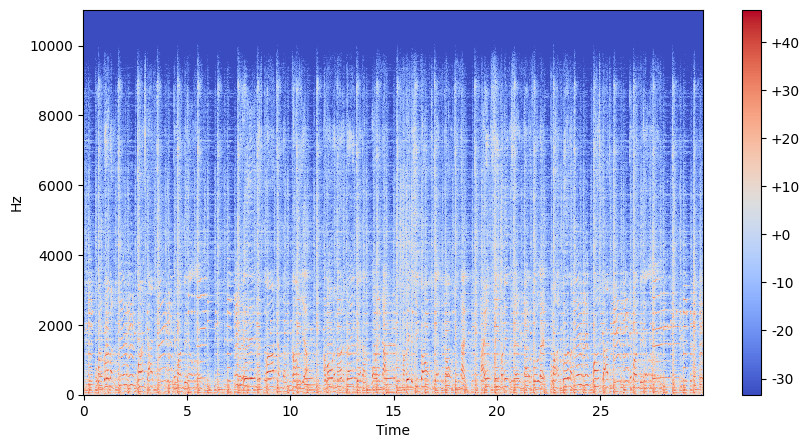

In [12]:
y, sr = librosa.load(r'genres\blues\blues.00000.au', duration=30)
y_log = librosa.power_to_db(np.abs(librosa.stft(y, hop_length=1024))**2)
plot_spectrogram(y_log, sr, 1024)

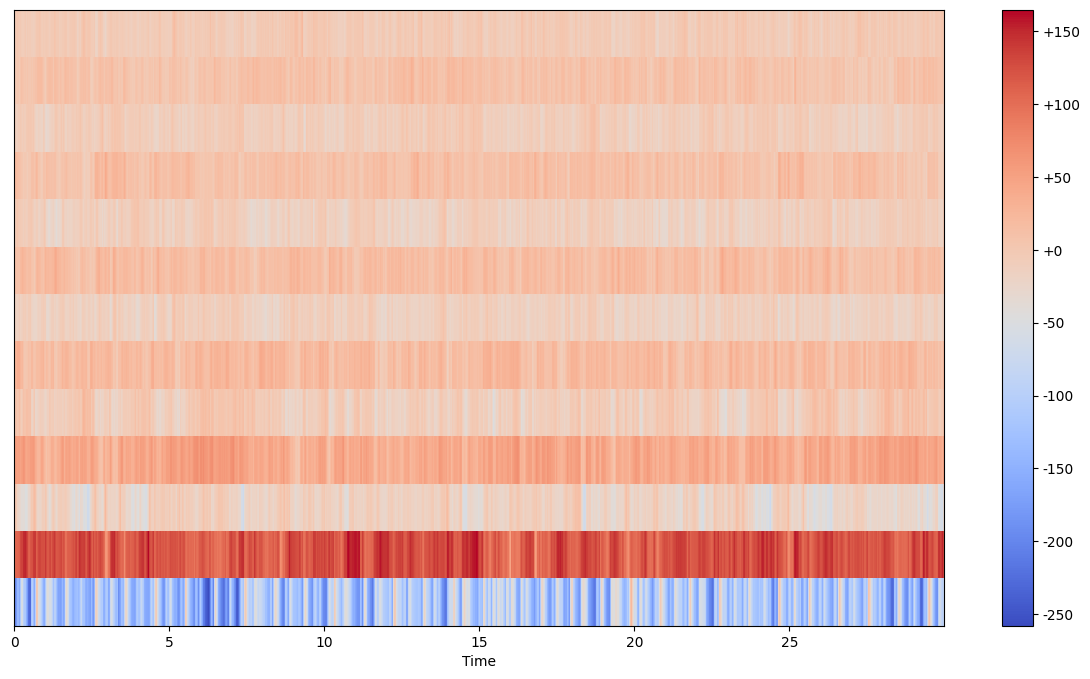

In [13]:
mfcc_song = librosa.feature.mfcc(y=y, n_mfcc=13, sr=sr)
plt.figure(figsize=(15, 8))
librosa.display.specshow(mfcc_song, x_axis="time", sr=sr)
plt.colorbar(format="%+2.f")
plt.show()

We need to generate more training examples since 1000 songs is not all that much. Slicing each song in 10 sub-parts seems like a reasonable size in order to retain enough information from their acoustic signature.

In [14]:
def data_preprocess(num_slices, duration, sr, samples_per_slice):
    data = {
        "labels": [],
        "mfcc": [],
        "song": [],
        }

    song_count = 1
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(r'genres')):
        for file in filenames:
            y, sr = librosa.load(os.path.join(dirpath, file), duration=duration)
            for j in range(num_slices):
                start = samples_per_slice * j
                end = start + samples_per_slice
                mfcc = librosa.feature.mfcc(y=y[start:end], sr=sr, n_mfcc=21).T
                data["labels"].append(i-1)
                data["mfcc"].append(mfcc.tolist())
                data["song"].append(song_count)
            song_count += 1

    with open('data.json', 'w') as f:
        json.dump(data, f)
    f.close()

    return 

In [15]:
def data_loading(path):
    with open(path, 'r') as f:
        data = json.load(f)
    f.close()

    X = np.array(data["mfcc"])[:,np.newaxis,:,:]
    y = np.array(data["labels"])
    groups = np.array(data["song"])
    return X, y, groups

In [16]:
num_slices = 10
duration = 29
sr = 22050
samples_per_slice = int(sr*duration/num_slices)

In [17]:
data_preprocess(num_slices, duration, sr, samples_per_slice)
X, y, groups = data_loading('data.json')

# 2. Model Training

Since we split each song into 10 slices and we have 10 classes, we want to do a stratified and grouped train validation test split to ensure that each subset has roughly the same class distribution (balanced) and each song's different slices will not be split into different subsets.

In [18]:
def stratified_group_train_val_test_split(X, y, groups):

    sgkf_1 = StratifiedGroupKFold(n_splits=10, shuffle=True, random_state=1)
    for i, (train_val_index, test_index) in enumerate(sgkf_1.split(X, y, groups)):
        break
    sgkf_2 = StratifiedGroupKFold(n_splits=9, shuffle=True, random_state=1)
    X_train_val = X[train_val_index]
    y_train_val = y[train_val_index]
    groups_train_val = groups[train_val_index]
    for i, (train_index, val_index) in enumerate(sgkf_2.split(X_train_val, y_train_val, groups_train_val)):
        break   

    X_train, y_train = X_train_val[train_index], y_train_val[train_index]
    X_val, y_val = X_train_val[val_index], y_train_val[val_index]
    X_test, y_test = X[test_index], y[test_index]

    return X_train, y_train, X_val, y_val, X_test, y_test

In [19]:
X_train, y_train, X_val, y_val, X_test, y_test = stratified_group_train_val_test_split(X, y, groups)

In [20]:
X_train.shape

(7990, 1, 125, 21)

In [21]:
# set dataloader
def form_dataloader(X, y, batch_size, shuffle):
    X = torch.tensor(X).float() # change float64 to float32
    y = torch.tensor(y).type(torch.LongTensor)
    data_tensor = data.TensorDataset(X,y)
    return data.DataLoader(data_tensor, batch_size, shuffle)

In [22]:
shuffle = True
batch_size = 16
train_data_iter = form_dataloader(X_train, y_train, batch_size, shuffle)
val_data_iter = form_dataloader(X_val, y_val, batch_size, shuffle)
test_data_iter = form_dataloader(X_test, y_test, batch_size, shuffle)

In [23]:
# design model structure
class CNN(nn.Module):
    def __init__(self, input_size, output_size, activation):
        super(CNN,self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        
        # define the layers needed
        # cnn
        self.cnn = nn.Sequential(
            # shape (None, 1, 125, 21)
            nn.Conv2d(self.input_size, 4, kernel_size=2, stride=1, padding=0),
            nn.BatchNorm2d(4),
            activation,
            nn.MaxPool2d(kernel_size=2, stride=2), 
            # shape (None, 4, 62, 10)
            nn.Conv2d(4, 8, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(8),
            activation,
            nn.MaxPool2d(kernel_size=2, stride=2),
            # shape (None, 8, 30, 4)
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(16),
            activation,
            nn.MaxPool2d(kernel_size=2, stride=2),
            # shape (None, 16, 14, 1)
            nn.Flatten(),
            nn.Linear(14*16*1,64), 
            activation, 
            nn.Dropout(0.5), 
            nn.Linear(64,32), 
            activation, 
            nn.Dropout(0.5), 
            nn.Linear(32,16), 
            activation, 
            nn.Dropout(0.5), 
            nn.Linear(16,output_size), 
            nn.Softmax(dim=-1))
        

    # used to forward propagate, will be called automatically
    # x here is the actual mini-batch that will be fed into the model, so contains sample dimension
    def forward(self, x):
        return self.cnn(x)

In [24]:
input_size = 1
output_size = 10
activation = nn.ReLU()
model = CNN(input_size, output_size, activation)
model

CNN(
  (cnn): Sequential(
    (0): Conv2d(1, 4, kernel_size=(2, 2), stride=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (9): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=224, out_features=64, bias=True)
    (14): ReLU()
    (15): Dropout(p=0.5, inplace=False)
    (16): Linear(in_features=64, out_features=32, bias=True)
    (17): Re

In [25]:
class Trainer():
    def __init__(self, epochs: int, lr:float, loss: str, optim: str, model, call_back:dict):
        self.epochs = epochs
        self.lr = lr
        self.loss = loss
        self.optim = optim
        # change data, model, and loss function onto GPU
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.model = model.to(self.device)
        self.call_back = call_back
        # store the batch sizes list
        self.batch_size_list = []
        
        
    def train(self, train_data_iter: data.DataLoader, val_data_iter: data.DataLoader):
        # define loss
        loss = self.__loss()
        loss = loss.to(self.device)
        # define optimizer
        optimizer = self.__optimizer()
        # check if we need to reduce lr dynamically
        if 'reducelr' in self.call_back.keys():
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer = optimizer, **self.call_back['reducelr'])
        # store the training and validating losses for each epoch (average of each batch)
        self.train_losses = []
        self.val_losses = []
        self.train_acc = []
        self.val_acc = []
        # for each epoch
        for epoch in range(self.epochs):
            loop = tqdm(enumerate(train_data_iter), total = len(iter(train_data_iter)))
            train_loss_epoch = []
            train_acc_epoch = 0
            # for each batch
            # batch variable stands for the Data stored in dataloader
            for index, (X,y) in loop:
                # store batch size using the first epoch
                if epoch == 0:
                    self.batch_size_list.append(X.shape[0])
                X = X.to(self.device)
                y = y.to(self.device)
                
                # calculate the loss (feed forward)
                output = self.model(X)
                l = loss(output,y)
                # clear the previous grads
                optimizer.zero_grad()
                # back propagate
                l.backward()
                # update weights
                optimizer.step()
                # calculate the training loss
                with torch.no_grad():
                    train_loss = l.cpu().data
                    train_loss_epoch.append(train_loss) 
                    train_acc_epoch += (output.argmax(-1) == y).sum().float().cpu().item()
                    

                
                # update information
                loop.set_description(f'Epoch [{epoch+1}/{self.epochs}]')
            
            # calculate the sample-average training loss
            train_loss = round(np.sum(np.array(train_loss_epoch) * np.array(self.batch_size_list)) / np.sum(self.batch_size_list),6)
            train_acc = round(train_acc_epoch / np.sum(self.batch_size_list), 4)
            # append the train averaged loss
            self.train_losses.append(train_loss)
            self.train_acc.append(train_acc)
            # use validation to evaluate
            val_loss, val_acc = self.evaluation(val_data_iter, loss)
            self.val_losses.append(val_loss)
            self.val_acc.append(val_acc)
            # print the result
            print(f'Train loss after epoch {(epoch+1):d} is: {train_loss:f}')
            print(f'Validation loss after epoch {(epoch+1):d} is: {val_loss:f}')
            print(f'Train Accuracy after epoch {(epoch+1):d} is: {train_acc:f}')
            print(f'Validation Accuracy after epoch {(epoch+1):d} is: {val_acc:f}')

            # callbacks:
            # reduce learning rate
            if 'reducelr' in self.call_back.keys():
                scheduler.step(val_loss)
            # Earlystopping
            if 'earlystopping' in self.call_back.keys():
                # store the best validation loss
                if epoch == 0:
                    self.best_loss = val_loss+0.1
                    self.patience = 0
                    self.best_weights = copy.deepcopy(self.model.state_dict())
                earlystopping = self.early_stop(val_loss)
                if earlystopping:
                    print('Early Stopping ...')
                    # save the best model without patience
                    self.model.load_state_dict(self.best_weights)
                    del self.best_weights
                    break
        
        # clear cache
        self.__release_cache()
        
        return
    
    def evaluation(self, val_data_iter: data.DataLoader, loss):
        val_batch_list = []
        val_loss_list = []
        val_acc = 0
        for (X,y) in val_data_iter:
            X = X.to(self.device)
            y = y.to(self.device)
            val_batch_list.append(X.shape[0])
            
            with torch.no_grad():
                output = self.model(X)
                val_loss = loss(output,y).cpu().data
                val_loss_list.append(val_loss)
                val_acc += (output.argmax(-1) == y).sum().float().cpu().item()
        # take average over all samples
        val_loss = round(np.sum(np.array(val_loss_list) * np.array(val_batch_list)) / np.sum(val_batch_list),6)
        val_acc = round(val_acc / np.sum(val_batch_list), 4)
        return val_loss, val_acc
    
    def early_stop(self, val_loss):
        params = self.call_back['earlystopping']
        if val_loss >= self.best_loss * (1 + params['threshold']):
            self.patience += 1
            print(f'Patience: {self.patience:d}')
            if self.patience >= params['patience']:
                return True
        elif val_loss < self.best_loss:
            self.best_loss = val_loss
            self.patience = 0
            # save the best model without patience
            self.best_weights = copy.deepcopy(self.model.state_dict())
        return False
        
        
    def training_graph(self):
        fig = make_subplots(rows=1, cols=2)
        fig.add_trace(go.Scatter(x=np.arange(self.epochs), y=self.train_losses, mode='lines', name='Train Loss'), row=1, col=1)
        fig.add_trace(go.Scatter(x=np.arange(self.epochs), y=self.val_losses, mode='lines', name='Validation Loss'), row=1, col=1)
        fig.add_trace(go.Scatter(x=np.arange(self.epochs), y=self.train_acc, mode='lines', name='Train Accuracy'), row=1, col=2)
        fig.add_trace(go.Scatter(x=np.arange(self.epochs), y=self.val_acc, mode='lines', name='Validation Accuracy'), row=1, col=2)
        fig.update_layout(
            title="Metrics Plot",
        ) 
        fig.update_yaxes(title_text="Loss", row=1, col=1)
        fig.update_yaxes(title_text="Accuracy", row=1, col=2)
        fig.update_xaxes(title_text="Epoch", row=1, col=1)
        fig.update_xaxes(title_text="Epoch", row=1, col=2)
        iplot(fig)
        
        return
        
    def save(self, path):
        if not os.path.exists(path):
            os.makedirs(path)
        torch.save(self.model, path+'model.pth')
    
    def __loss(self):
        if self.loss == 'nll':
            return nn.NLLLoss() # already take the average over batch_size
        elif self.loss == 'crossentorpy':
            return nn.CrossEntropyLoss()
        else:
            raise ValueError('Undefined Loss Function.')

        
    def __optimizer(self):
        if self.optim == 'sgd':
            return torch.optim.SGD(self.model.parameters(), lr=self.lr)
        elif self.optim == 'Adam':
            return torch.optim.Adam(self.model.parameters(), lr=self.lr)
        elif self.optim == 'rms':
            return torch.optim.RMSprop(self.model.parameters(), lr=self.lr)
        
    def __release_cache(self):
        torch.cuda.empty_cache()

In [26]:
call_back = {'earlystopping':{'patience':20, 'threshold':0}, 
             'reducelr':{'factor':0.25, 'patience':5, 'threshold':0, 'min_lr': 1e-6, 'verbose':True}}
epochs = 1000
lr = 0.001
trainer = Trainer(epochs = epochs, lr = lr, loss = 'crossentorpy', optim = 'rms', model = model, call_back = call_back)
trainer.train(train_data_iter, val_data_iter)

Epoch [1/1000]: 100%|██████████| 500/500 [00:04<00:00, 122.22it/s]


Train loss after epoch 1 is: 2.236248
Validation loss after epoch 1 is: 2.204408
Train Accuracy after epoch 1 is: 0.183500
Validation Accuracy after epoch 1 is: 0.240600


Epoch [2/1000]: 100%|██████████| 500/500 [00:01<00:00, 272.79it/s]


Train loss after epoch 2 is: 2.191809
Validation loss after epoch 2 is: 2.183655
Train Accuracy after epoch 2 is: 0.277200
Validation Accuracy after epoch 2 is: 0.273300


Epoch [3/1000]: 100%|██████████| 500/500 [00:01<00:00, 285.72it/s]


Train loss after epoch 3 is: 2.171715
Validation loss after epoch 3 is: 2.161582
Train Accuracy after epoch 3 is: 0.290500
Validation Accuracy after epoch 3 is: 0.301000


Epoch [4/1000]: 100%|██████████| 500/500 [00:01<00:00, 283.15it/s]


Train loss after epoch 4 is: 2.154888
Validation loss after epoch 4 is: 2.149609
Train Accuracy after epoch 4 is: 0.305900
Validation Accuracy after epoch 4 is: 0.323800


Epoch [5/1000]: 100%|██████████| 500/500 [00:01<00:00, 284.48it/s]


Train loss after epoch 5 is: 2.146368
Validation loss after epoch 5 is: 2.153712
Train Accuracy after epoch 5 is: 0.323900
Validation Accuracy after epoch 5 is: 0.318800
Patience: 1


Epoch [6/1000]: 100%|██████████| 500/500 [00:01<00:00, 302.42it/s]


Train loss after epoch 6 is: 2.138296
Validation loss after epoch 6 is: 2.122334
Train Accuracy after epoch 6 is: 0.330800
Validation Accuracy after epoch 6 is: 0.352500


Epoch [7/1000]: 100%|██████████| 500/500 [00:01<00:00, 329.79it/s]


Train loss after epoch 7 is: 2.129378
Validation loss after epoch 7 is: 2.113858
Train Accuracy after epoch 7 is: 0.337800
Validation Accuracy after epoch 7 is: 0.353500


Epoch [8/1000]: 100%|██████████| 500/500 [00:01<00:00, 300.87it/s]


Train loss after epoch 8 is: 2.120014
Validation loss after epoch 8 is: 2.127305
Train Accuracy after epoch 8 is: 0.345200
Validation Accuracy after epoch 8 is: 0.329700
Patience: 1


Epoch [9/1000]: 100%|██████████| 500/500 [00:01<00:00, 292.57it/s]


Train loss after epoch 9 is: 2.113644
Validation loss after epoch 9 is: 2.114459
Train Accuracy after epoch 9 is: 0.354200
Validation Accuracy after epoch 9 is: 0.361400
Patience: 2


Epoch [10/1000]: 100%|██████████| 500/500 [00:01<00:00, 296.51it/s]


Train loss after epoch 10 is: 2.105741
Validation loss after epoch 10 is: 2.087671
Train Accuracy after epoch 10 is: 0.356900
Validation Accuracy after epoch 10 is: 0.386100


Epoch [11/1000]: 100%|██████████| 500/500 [00:01<00:00, 300.37it/s]


Train loss after epoch 11 is: 2.098593
Validation loss after epoch 11 is: 2.083328
Train Accuracy after epoch 11 is: 0.367300
Validation Accuracy after epoch 11 is: 0.380200


Epoch [12/1000]: 100%|██████████| 500/500 [00:01<00:00, 293.86it/s]


Train loss after epoch 12 is: 2.086380
Validation loss after epoch 12 is: 2.069404
Train Accuracy after epoch 12 is: 0.377200
Validation Accuracy after epoch 12 is: 0.393100


Epoch [13/1000]: 100%|██████████| 500/500 [00:01<00:00, 296.28it/s]


Train loss after epoch 13 is: 2.074381
Validation loss after epoch 13 is: 2.063599
Train Accuracy after epoch 13 is: 0.389000
Validation Accuracy after epoch 13 is: 0.398000


Epoch [14/1000]: 100%|██████████| 500/500 [00:01<00:00, 293.04it/s]


Train loss after epoch 14 is: 2.070077
Validation loss after epoch 14 is: 2.081085
Train Accuracy after epoch 14 is: 0.390900
Validation Accuracy after epoch 14 is: 0.381200
Patience: 1


Epoch [15/1000]: 100%|██████████| 500/500 [00:01<00:00, 296.47it/s]


Train loss after epoch 15 is: 2.062263
Validation loss after epoch 15 is: 2.037237
Train Accuracy after epoch 15 is: 0.400900
Validation Accuracy after epoch 15 is: 0.425700


Epoch [16/1000]: 100%|██████████| 500/500 [00:01<00:00, 296.26it/s]


Train loss after epoch 16 is: 2.060205
Validation loss after epoch 16 is: 2.040692
Train Accuracy after epoch 16 is: 0.402900
Validation Accuracy after epoch 16 is: 0.421800
Patience: 1


Epoch [17/1000]: 100%|██████████| 500/500 [00:01<00:00, 319.89it/s]


Train loss after epoch 17 is: 2.046841
Validation loss after epoch 17 is: 2.046968
Train Accuracy after epoch 17 is: 0.413100
Validation Accuracy after epoch 17 is: 0.405000
Patience: 2


Epoch [18/1000]: 100%|██████████| 500/500 [00:01<00:00, 305.80it/s]


Train loss after epoch 18 is: 2.039682
Validation loss after epoch 18 is: 2.051530
Train Accuracy after epoch 18 is: 0.422800
Validation Accuracy after epoch 18 is: 0.408900
Patience: 3


Epoch [19/1000]: 100%|██████████| 500/500 [00:01<00:00, 287.22it/s]


Train loss after epoch 19 is: 2.037141
Validation loss after epoch 19 is: 2.037579
Train Accuracy after epoch 19 is: 0.424300
Validation Accuracy after epoch 19 is: 0.422800
Patience: 4


Epoch [20/1000]: 100%|██████████| 500/500 [00:01<00:00, 304.35it/s]


Train loss after epoch 20 is: 2.034729
Validation loss after epoch 20 is: 2.032537
Train Accuracy after epoch 20 is: 0.421900
Validation Accuracy after epoch 20 is: 0.433700


Epoch [21/1000]: 100%|██████████| 500/500 [00:01<00:00, 304.54it/s]


Train loss after epoch 21 is: 2.030945
Validation loss after epoch 21 is: 2.026060
Train Accuracy after epoch 21 is: 0.427300
Validation Accuracy after epoch 21 is: 0.429700


Epoch [22/1000]: 100%|██████████| 500/500 [00:01<00:00, 304.70it/s]


Train loss after epoch 22 is: 2.026425
Validation loss after epoch 22 is: 2.019841
Train Accuracy after epoch 22 is: 0.431700
Validation Accuracy after epoch 22 is: 0.435600


Epoch [23/1000]: 100%|██████████| 500/500 [00:01<00:00, 294.01it/s]


Train loss after epoch 23 is: 2.020106
Validation loss after epoch 23 is: 2.003902
Train Accuracy after epoch 23 is: 0.434700
Validation Accuracy after epoch 23 is: 0.456400


Epoch [24/1000]: 100%|██████████| 500/500 [00:01<00:00, 301.88it/s]


Train loss after epoch 24 is: 2.016722
Validation loss after epoch 24 is: 2.036001
Train Accuracy after epoch 24 is: 0.443100
Validation Accuracy after epoch 24 is: 0.418800
Patience: 1


Epoch [25/1000]: 100%|██████████| 500/500 [00:01<00:00, 313.15it/s]


Train loss after epoch 25 is: 2.008410
Validation loss after epoch 25 is: 2.025532
Train Accuracy after epoch 25 is: 0.451200
Validation Accuracy after epoch 25 is: 0.424800
Patience: 2


Epoch [26/1000]: 100%|██████████| 500/500 [00:01<00:00, 334.91it/s]


Train loss after epoch 26 is: 2.005073
Validation loss after epoch 26 is: 2.011865
Train Accuracy after epoch 26 is: 0.452900
Validation Accuracy after epoch 26 is: 0.444600
Patience: 3


Epoch [27/1000]: 100%|██████████| 500/500 [00:01<00:00, 329.98it/s]


Train loss after epoch 27 is: 2.005350
Validation loss after epoch 27 is: 2.033517
Train Accuracy after epoch 27 is: 0.453400
Validation Accuracy after epoch 27 is: 0.425700
Patience: 4


Epoch [28/1000]: 100%|██████████| 500/500 [00:01<00:00, 334.70it/s]


Train loss after epoch 28 is: 2.000851
Validation loss after epoch 28 is: 2.014264
Train Accuracy after epoch 28 is: 0.459400
Validation Accuracy after epoch 28 is: 0.444600
Patience: 5


Epoch [29/1000]: 100%|██████████| 500/500 [00:01<00:00, 322.61it/s]


Train loss after epoch 29 is: 2.002326
Validation loss after epoch 29 is: 2.012677
Train Accuracy after epoch 29 is: 0.458800
Validation Accuracy after epoch 29 is: 0.451500
Epoch 00029: reducing learning rate of group 0 to 2.5000e-04.
Patience: 6


Epoch [30/1000]: 100%|██████████| 500/500 [00:01<00:00, 327.34it/s]


Train loss after epoch 30 is: 1.989896
Validation loss after epoch 30 is: 1.995321
Train Accuracy after epoch 30 is: 0.470500
Validation Accuracy after epoch 30 is: 0.470300


Epoch [31/1000]: 100%|██████████| 500/500 [00:01<00:00, 321.08it/s]


Train loss after epoch 31 is: 1.979090
Validation loss after epoch 31 is: 1.991056
Train Accuracy after epoch 31 is: 0.483900
Validation Accuracy after epoch 31 is: 0.461400


Epoch [32/1000]: 100%|██████████| 500/500 [00:01<00:00, 330.56it/s]


Train loss after epoch 32 is: 1.976886
Validation loss after epoch 32 is: 1.998524
Train Accuracy after epoch 32 is: 0.487200
Validation Accuracy after epoch 32 is: 0.468300
Patience: 1


Epoch [33/1000]: 100%|██████████| 500/500 [00:01<00:00, 318.99it/s]


Train loss after epoch 33 is: 1.975370
Validation loss after epoch 33 is: 1.990960
Train Accuracy after epoch 33 is: 0.487100
Validation Accuracy after epoch 33 is: 0.465300


Epoch [34/1000]: 100%|██████████| 500/500 [00:01<00:00, 334.11it/s]


Train loss after epoch 34 is: 1.966295
Validation loss after epoch 34 is: 1.997438
Train Accuracy after epoch 34 is: 0.494700
Validation Accuracy after epoch 34 is: 0.461400
Patience: 1


Epoch [35/1000]: 100%|██████████| 500/500 [00:01<00:00, 326.30it/s]


Train loss after epoch 35 is: 1.979193
Validation loss after epoch 35 is: 1.989025
Train Accuracy after epoch 35 is: 0.481900
Validation Accuracy after epoch 35 is: 0.472300


Epoch [36/1000]: 100%|██████████| 500/500 [00:01<00:00, 327.84it/s]


Train loss after epoch 36 is: 1.969197
Validation loss after epoch 36 is: 1.994290
Train Accuracy after epoch 36 is: 0.492500
Validation Accuracy after epoch 36 is: 0.467300
Patience: 1


Epoch [37/1000]: 100%|██████████| 500/500 [00:01<00:00, 326.03it/s]


Train loss after epoch 37 is: 1.964173
Validation loss after epoch 37 is: 1.968064
Train Accuracy after epoch 37 is: 0.499900
Validation Accuracy after epoch 37 is: 0.490100


Epoch [38/1000]: 100%|██████████| 500/500 [00:01<00:00, 322.40it/s]


Train loss after epoch 38 is: 1.960681
Validation loss after epoch 38 is: 1.982807
Train Accuracy after epoch 38 is: 0.502500
Validation Accuracy after epoch 38 is: 0.478200
Patience: 1


Epoch [39/1000]: 100%|██████████| 500/500 [00:01<00:00, 325.63it/s]


Train loss after epoch 39 is: 1.964394
Validation loss after epoch 39 is: 1.979608
Train Accuracy after epoch 39 is: 0.498500
Validation Accuracy after epoch 39 is: 0.483200
Patience: 2


Epoch [40/1000]: 100%|██████████| 500/500 [00:01<00:00, 326.50it/s]


Train loss after epoch 40 is: 1.968565
Validation loss after epoch 40 is: 1.985840
Train Accuracy after epoch 40 is: 0.495500
Validation Accuracy after epoch 40 is: 0.481200
Patience: 3


Epoch [41/1000]: 100%|██████████| 500/500 [00:01<00:00, 330.22it/s]


Train loss after epoch 41 is: 1.963072
Validation loss after epoch 41 is: 1.957992
Train Accuracy after epoch 41 is: 0.501500
Validation Accuracy after epoch 41 is: 0.505900


Epoch [42/1000]: 100%|██████████| 500/500 [00:01<00:00, 331.32it/s]


Train loss after epoch 42 is: 1.964594
Validation loss after epoch 42 is: 1.972686
Train Accuracy after epoch 42 is: 0.495600
Validation Accuracy after epoch 42 is: 0.492100
Patience: 1


Epoch [43/1000]: 100%|██████████| 500/500 [00:01<00:00, 336.44it/s]


Train loss after epoch 43 is: 1.961870
Validation loss after epoch 43 is: 1.973112
Train Accuracy after epoch 43 is: 0.500900
Validation Accuracy after epoch 43 is: 0.487100
Patience: 2


Epoch [44/1000]: 100%|██████████| 500/500 [00:01<00:00, 315.93it/s]


Train loss after epoch 44 is: 1.963250
Validation loss after epoch 44 is: 1.954150
Train Accuracy after epoch 44 is: 0.499500
Validation Accuracy after epoch 44 is: 0.515800


Epoch [45/1000]: 100%|██████████| 500/500 [00:01<00:00, 330.09it/s]


Train loss after epoch 45 is: 1.958631
Validation loss after epoch 45 is: 1.985128
Train Accuracy after epoch 45 is: 0.505100
Validation Accuracy after epoch 45 is: 0.464400
Patience: 1


Epoch [46/1000]: 100%|██████████| 500/500 [00:01<00:00, 319.36it/s]


Train loss after epoch 46 is: 1.958945
Validation loss after epoch 46 is: 1.983690
Train Accuracy after epoch 46 is: 0.502900
Validation Accuracy after epoch 46 is: 0.482200
Patience: 2


Epoch [47/1000]: 100%|██████████| 500/500 [00:01<00:00, 337.02it/s]


Train loss after epoch 47 is: 1.952705
Validation loss after epoch 47 is: 1.954581
Train Accuracy after epoch 47 is: 0.510400
Validation Accuracy after epoch 47 is: 0.509900
Patience: 3


Epoch [48/1000]: 100%|██████████| 500/500 [00:01<00:00, 321.60it/s]


Train loss after epoch 48 is: 1.958515
Validation loss after epoch 48 is: 1.985120
Train Accuracy after epoch 48 is: 0.501400
Validation Accuracy after epoch 48 is: 0.479200
Patience: 4


Epoch [49/1000]: 100%|██████████| 500/500 [00:01<00:00, 340.94it/s]


Train loss after epoch 49 is: 1.950023
Validation loss after epoch 49 is: 1.968922
Train Accuracy after epoch 49 is: 0.512400
Validation Accuracy after epoch 49 is: 0.498000
Patience: 5


Epoch [50/1000]: 100%|██████████| 500/500 [00:01<00:00, 329.46it/s]


Train loss after epoch 50 is: 1.958989
Validation loss after epoch 50 is: 1.959515
Train Accuracy after epoch 50 is: 0.504900
Validation Accuracy after epoch 50 is: 0.501000
Epoch 00050: reducing learning rate of group 0 to 6.2500e-05.
Patience: 6


Epoch [51/1000]: 100%|██████████| 500/500 [00:01<00:00, 325.16it/s]


Train loss after epoch 51 is: 1.954760
Validation loss after epoch 51 is: 1.972658
Train Accuracy after epoch 51 is: 0.507100
Validation Accuracy after epoch 51 is: 0.496000
Patience: 7


Epoch [52/1000]: 100%|██████████| 500/500 [00:01<00:00, 326.63it/s]


Train loss after epoch 52 is: 1.944182
Validation loss after epoch 52 is: 1.960186
Train Accuracy after epoch 52 is: 0.522500
Validation Accuracy after epoch 52 is: 0.500000
Patience: 8


Epoch [53/1000]: 100%|██████████| 500/500 [00:01<00:00, 331.57it/s]


Train loss after epoch 53 is: 1.948788
Validation loss after epoch 53 is: 1.950805
Train Accuracy after epoch 53 is: 0.514600
Validation Accuracy after epoch 53 is: 0.518800


Epoch [54/1000]: 100%|██████████| 500/500 [00:01<00:00, 344.59it/s]


Train loss after epoch 54 is: 1.948666
Validation loss after epoch 54 is: 1.950763
Train Accuracy after epoch 54 is: 0.514500
Validation Accuracy after epoch 54 is: 0.521800


Epoch [55/1000]: 100%|██████████| 500/500 [00:01<00:00, 314.61it/s]


Train loss after epoch 55 is: 1.949366
Validation loss after epoch 55 is: 1.959204
Train Accuracy after epoch 55 is: 0.511400
Validation Accuracy after epoch 55 is: 0.505900
Patience: 1


Epoch [56/1000]: 100%|██████████| 500/500 [00:01<00:00, 340.17it/s]


Train loss after epoch 56 is: 1.944575
Validation loss after epoch 56 is: 1.949955
Train Accuracy after epoch 56 is: 0.521700
Validation Accuracy after epoch 56 is: 0.516800


Epoch [57/1000]: 100%|██████████| 500/500 [00:01<00:00, 311.79it/s]


Train loss after epoch 57 is: 1.942915
Validation loss after epoch 57 is: 1.961725
Train Accuracy after epoch 57 is: 0.520400
Validation Accuracy after epoch 57 is: 0.497000
Patience: 1


Epoch [58/1000]: 100%|██████████| 500/500 [00:01<00:00, 331.31it/s]


Train loss after epoch 58 is: 1.941734
Validation loss after epoch 58 is: 1.964808
Train Accuracy after epoch 58 is: 0.521800
Validation Accuracy after epoch 58 is: 0.503000
Patience: 2


Epoch [59/1000]: 100%|██████████| 500/500 [00:01<00:00, 316.67it/s]


Train loss after epoch 59 is: 1.946122
Validation loss after epoch 59 is: 1.949536
Train Accuracy after epoch 59 is: 0.518300
Validation Accuracy after epoch 59 is: 0.517800


Epoch [60/1000]: 100%|██████████| 500/500 [00:01<00:00, 337.95it/s]


Train loss after epoch 60 is: 1.937093
Validation loss after epoch 60 is: 1.960365
Train Accuracy after epoch 60 is: 0.530300
Validation Accuracy after epoch 60 is: 0.502000
Patience: 1


Epoch [61/1000]: 100%|██████████| 500/500 [00:01<00:00, 314.13it/s]


Train loss after epoch 61 is: 1.943801
Validation loss after epoch 61 is: 1.956057
Train Accuracy after epoch 61 is: 0.520900
Validation Accuracy after epoch 61 is: 0.510900
Patience: 2


Epoch [62/1000]: 100%|██████████| 500/500 [00:01<00:00, 335.55it/s]


Train loss after epoch 62 is: 1.941250
Validation loss after epoch 62 is: 1.956092
Train Accuracy after epoch 62 is: 0.522700
Validation Accuracy after epoch 62 is: 0.512900
Patience: 3


Epoch [63/1000]: 100%|██████████| 500/500 [00:01<00:00, 333.33it/s]


Train loss after epoch 63 is: 1.946951
Validation loss after epoch 63 is: 1.968253
Train Accuracy after epoch 63 is: 0.519500
Validation Accuracy after epoch 63 is: 0.497000
Patience: 4


Epoch [64/1000]: 100%|██████████| 500/500 [00:01<00:00, 336.49it/s]


Train loss after epoch 64 is: 1.943308
Validation loss after epoch 64 is: 1.962668
Train Accuracy after epoch 64 is: 0.521500
Validation Accuracy after epoch 64 is: 0.505900
Patience: 5


Epoch [65/1000]: 100%|██████████| 500/500 [00:01<00:00, 329.75it/s]


Train loss after epoch 65 is: 1.946652
Validation loss after epoch 65 is: 1.963103
Train Accuracy after epoch 65 is: 0.513900
Validation Accuracy after epoch 65 is: 0.502000
Epoch 00065: reducing learning rate of group 0 to 1.5625e-05.
Patience: 6


Epoch [66/1000]: 100%|██████████| 500/500 [00:01<00:00, 342.72it/s]


Train loss after epoch 66 is: 1.941346
Validation loss after epoch 66 is: 1.957631
Train Accuracy after epoch 66 is: 0.523300
Validation Accuracy after epoch 66 is: 0.505000
Patience: 7


Epoch [67/1000]: 100%|██████████| 500/500 [00:01<00:00, 327.31it/s]


Train loss after epoch 67 is: 1.944336
Validation loss after epoch 67 is: 1.946996
Train Accuracy after epoch 67 is: 0.522300
Validation Accuracy after epoch 67 is: 0.520800


Epoch [68/1000]: 100%|██████████| 500/500 [00:01<00:00, 335.52it/s]


Train loss after epoch 68 is: 1.939351
Validation loss after epoch 68 is: 1.973332
Train Accuracy after epoch 68 is: 0.526700
Validation Accuracy after epoch 68 is: 0.489100
Patience: 1


Epoch [69/1000]: 100%|██████████| 500/500 [00:01<00:00, 332.75it/s]


Train loss after epoch 69 is: 1.943991
Validation loss after epoch 69 is: 1.964784
Train Accuracy after epoch 69 is: 0.518500
Validation Accuracy after epoch 69 is: 0.499000
Patience: 2


Epoch [70/1000]: 100%|██████████| 500/500 [00:01<00:00, 335.34it/s]


Train loss after epoch 70 is: 1.942825
Validation loss after epoch 70 is: 1.960396
Train Accuracy after epoch 70 is: 0.522000
Validation Accuracy after epoch 70 is: 0.504000
Patience: 3


Epoch [71/1000]: 100%|██████████| 500/500 [00:01<00:00, 330.56it/s]


Train loss after epoch 71 is: 1.945344
Validation loss after epoch 71 is: 1.957667
Train Accuracy after epoch 71 is: 0.516500
Validation Accuracy after epoch 71 is: 0.505900
Patience: 4


Epoch [72/1000]: 100%|██████████| 500/500 [00:01<00:00, 331.47it/s]


Train loss after epoch 72 is: 1.939317
Validation loss after epoch 72 is: 1.948750
Train Accuracy after epoch 72 is: 0.523800
Validation Accuracy after epoch 72 is: 0.515800
Patience: 5


Epoch [73/1000]: 100%|██████████| 500/500 [00:01<00:00, 340.31it/s]


Train loss after epoch 73 is: 1.939466
Validation loss after epoch 73 is: 1.960629
Train Accuracy after epoch 73 is: 0.523300
Validation Accuracy after epoch 73 is: 0.502000
Epoch 00073: reducing learning rate of group 0 to 3.9063e-06.
Patience: 6


Epoch [74/1000]: 100%|██████████| 500/500 [00:01<00:00, 328.14it/s]


Train loss after epoch 74 is: 1.940782
Validation loss after epoch 74 is: 1.964504
Train Accuracy after epoch 74 is: 0.522400
Validation Accuracy after epoch 74 is: 0.497000
Patience: 7


Epoch [75/1000]: 100%|██████████| 500/500 [00:01<00:00, 336.22it/s]


Train loss after epoch 75 is: 1.940948
Validation loss after epoch 75 is: 1.979167
Train Accuracy after epoch 75 is: 0.521700
Validation Accuracy after epoch 75 is: 0.480200
Patience: 8


Epoch [76/1000]: 100%|██████████| 500/500 [00:01<00:00, 334.00it/s]


Train loss after epoch 76 is: 1.940251
Validation loss after epoch 76 is: 1.958297
Train Accuracy after epoch 76 is: 0.523800
Validation Accuracy after epoch 76 is: 0.505000
Patience: 9


Epoch [77/1000]: 100%|██████████| 500/500 [00:01<00:00, 312.00it/s]


Train loss after epoch 77 is: 1.942751
Validation loss after epoch 77 is: 1.964208
Train Accuracy after epoch 77 is: 0.519100
Validation Accuracy after epoch 77 is: 0.499000
Patience: 10


Epoch [78/1000]: 100%|██████████| 500/500 [00:01<00:00, 318.08it/s]


Train loss after epoch 78 is: 1.944190
Validation loss after epoch 78 is: 1.963206
Train Accuracy after epoch 78 is: 0.520300
Validation Accuracy after epoch 78 is: 0.489100
Patience: 11


Epoch [79/1000]: 100%|██████████| 500/500 [00:01<00:00, 329.51it/s]


Train loss after epoch 79 is: 1.948342
Validation loss after epoch 79 is: 1.948013
Train Accuracy after epoch 79 is: 0.515000
Validation Accuracy after epoch 79 is: 0.531700
Epoch 00079: reducing learning rate of group 0 to 1.0000e-06.
Patience: 12


Epoch [80/1000]: 100%|██████████| 500/500 [00:01<00:00, 329.12it/s]


Train loss after epoch 80 is: 1.940034
Validation loss after epoch 80 is: 1.950540
Train Accuracy after epoch 80 is: 0.523700
Validation Accuracy after epoch 80 is: 0.519800
Patience: 13


Epoch [81/1000]: 100%|██████████| 500/500 [00:01<00:00, 338.25it/s]


Train loss after epoch 81 is: 1.934457
Validation loss after epoch 81 is: 1.954478
Train Accuracy after epoch 81 is: 0.532200
Validation Accuracy after epoch 81 is: 0.511900
Patience: 14


Epoch [82/1000]: 100%|██████████| 500/500 [00:01<00:00, 347.19it/s]


Train loss after epoch 82 is: 1.943387
Validation loss after epoch 82 is: 1.967318
Train Accuracy after epoch 82 is: 0.518100
Validation Accuracy after epoch 82 is: 0.506900
Patience: 15


Epoch [83/1000]: 100%|██████████| 500/500 [00:01<00:00, 320.10it/s]


Train loss after epoch 83 is: 1.945944
Validation loss after epoch 83 is: 1.951048
Train Accuracy after epoch 83 is: 0.519100
Validation Accuracy after epoch 83 is: 0.510900
Patience: 16


Epoch [84/1000]: 100%|██████████| 500/500 [00:01<00:00, 333.67it/s]


Train loss after epoch 84 is: 1.943055
Validation loss after epoch 84 is: 1.950038
Train Accuracy after epoch 84 is: 0.520400
Validation Accuracy after epoch 84 is: 0.515800
Patience: 17


Epoch [85/1000]: 100%|██████████| 500/500 [00:01<00:00, 328.90it/s]


Train loss after epoch 85 is: 1.948320
Validation loss after epoch 85 is: 1.960703
Train Accuracy after epoch 85 is: 0.516600
Validation Accuracy after epoch 85 is: 0.497000
Patience: 18


Epoch [86/1000]: 100%|██████████| 500/500 [00:01<00:00, 332.99it/s]


Train loss after epoch 86 is: 1.943973
Validation loss after epoch 86 is: 1.955671
Train Accuracy after epoch 86 is: 0.519600
Validation Accuracy after epoch 86 is: 0.505000
Patience: 19


Epoch [87/1000]: 100%|██████████| 500/500 [00:01<00:00, 325.46it/s]


Train loss after epoch 87 is: 1.936528
Validation loss after epoch 87 is: 1.971555
Train Accuracy after epoch 87 is: 0.525700
Validation Accuracy after epoch 87 is: 0.490100
Patience: 20
Early Stopping ...


In [27]:
trainer.training_graph()

# 3. Model Testing

In [31]:
def predict(data_iter, model):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    pred = []
    corrects = 0
    total_size = 0
    for (X,y) in tqdm(data_iter):
        batch_size = X.shape[0]
        total_size += batch_size
        X = X.to(device)
        y = y.to(device)
        # add this when do not need to record gradients
        with torch.no_grad():
            # calculate the loss
            output = model(X)
            corrects += (output.argmax(-1)==y).sum().cpu().item()
            pred += output.argmax(-1).cpu().numpy().tolist()
    # clear cache
    torch.cuda.empty_cache()
    
    return np.array(pred), corrects / total_size

In [32]:
predicted, accuracy = predict(test_data_iter, model)

100%|██████████| 63/63 [00:00<00:00, 270.49it/s]


In [33]:
print(f'The accuracy for the test data set is {accuracy}')

The accuracy for the test data set is 0.472
